## HMcode demo with baryonic feedback

Here we calculate the suppression of the matter-matter power spectrum due to baryonic-feedback effects, using the baryon model from `HMCode2020`.

First, import the necessary libraries

In [6]:
# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import camb

# Project imports
import hmcode

Set some parameters

In [7]:
# Cosmology
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
ns = 0.96
sigma_8 = 0.8
w0 = -1.
wa = 0.
m_nu = 0.
norm_sigma8 = True
As = 2e-9

# AGN-feedback temperature [K]
T_AGNs = np.power(10, np.array([7.6, 7.8, 8.0, 8.3]))

# CAMB
kmax_CAMB = 200.

# Wavenumbers [h/Mpc]
kmin, kmax = 1e-3, 3e1
nk = 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk)

# Redshifts
zs = [1., 0.5, 0.25, 0.]
zs = np.array(zs)

# Halo masses [Msun/h] (for halo model only)
Mmin, Mmax = 1e0, 1e18
nM = 256
M = np.logspace(np.log10(Mmin), np.log10(Mmax), nM)


Run `CAMB` to get the linear spectrum and $\sigma(R)$

In [8]:
# Sets cosmological parameters in camb to calculate the linear power spectrum
pars = camb.CAMBparams(WantCls=False)
wb, wc = Omega_b*h**2, Omega_c*h**2

# This function sets standard and helium set using BBN consistency
pars.set_cosmology(ombh2=wb, omch2=wc, H0=100.*h, mnu=m_nu, omk=Omega_k)
pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')
pars.InitPower.set_params(As=As, ns=ns, r=0.)
pars.set_matter_power(redshifts=zs, kmax=kmax_CAMB) # Setup the linear matter power spectrum
Omega_m = pars.omegam # Extract the matter density

# Scale 'As' to be correct for the desired 'sigma_8' value if necessary
if norm_sigma8:
    results = camb.get_results(pars)
    sigma_8_init = results.get_sigma8_0()
    print('Running CAMB')
    print('Initial sigma_8:', sigma_8_init)
    print('Desired sigma_8:', sigma_8)
    scaling = (sigma_8/sigma_8_init)**2
    As *= scaling
    pars.InitPower.set_params(As=As, ns=ns, r=0.)

# Run
results = camb.get_results(pars)
Pk_lin_interp = results.get_matter_power_interpolator(nonlinear=False).P
Pk_nonlin_interp = results.get_matter_power_interpolator(nonlinear=True).P
sigma_8 = results.get_sigma8_0()
print('Final sigma_8:', sigma_8)

# Arrays for CAMB non-linear spectrum
Pk_CAMB = np.zeros((len(zs), len(k)))
for iz, z in enumerate(zs):
    Pk_CAMB[iz, :] = Pk_nonlin_interp(z, k)

Running CAMB
Initial sigma_8: 0.8051418118154231
Desired sigma_8: 0.8
Final sigma_8: 0.8


Get the suppression from `HMcode`, note that it takes the results data structure from `CAMB` as an argument

In [9]:
Rk_feedback = []
for T_AGN in T_AGNs:
    Pk_feedback = hmcode.power(k, zs, results, T_AGN=T_AGN, verbose=False)
    Pk_gravity = hmcode.power(k, zs, results, T_AGN=None)
    Rk = Pk_feedback/Pk_gravity
    Rk_feedback.append(Rk)

Finally we recreate Figure 5 from [Mead et al. (2021)](https://arxiv.org/abs/2009.01858)

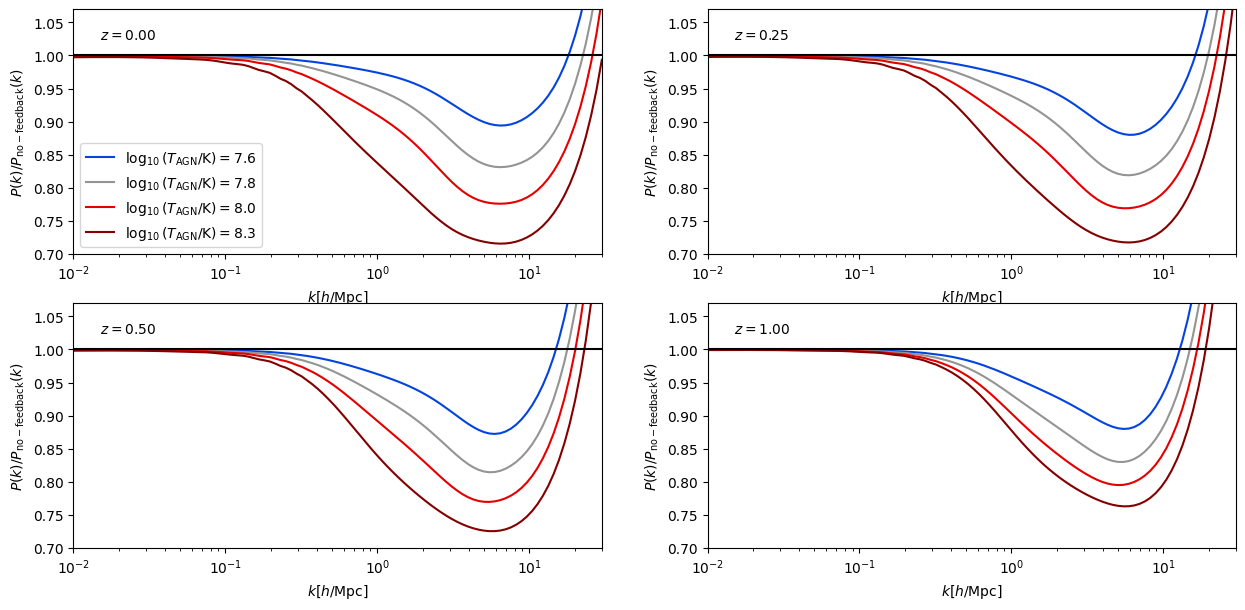

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,7))

colors=['xkcd:blue', 'xkcd:grey',  'xkcd:red', 'xkcd:dark red']

for j, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_xlabel(r'$k [h/\mathrm{Mpc}]$')
    ax.set_ylabel(r'$P(k)/P_\mathrm{no-feedback}(k)$')
    ax.set_ylim((0.7, 1.07))
    ax.set_xlim(0.01, 30)
    for i, Rk in enumerate(Rk_feedback):
        label=rf'$\log_{{10}}(T_\mathrm{{AGN}}/\mathrm{{K}}) = {np.log10(T_AGNs[i])}$' if j == 0 else None
        ax.plot(k, Rk[3-j], ls='-', label=label, color=colors[i])
    ax.text(0.015, 1.025, r'$z = {:.2f}$'.format(zs[3-j]))
    ax.plot(k, [1]*len(k), color='k')
    if j==0: ax.legend()
